# ECBM 4040 - Assignment 1, Task 3: Dimensionality Reduction

Here is the third part and it is about dimentionality reduction. How to map high-dimentional data into low-dimensional space is an interesting topic in machine learning field. And also, it is related to another hot topic -- unsupervised learning. Now, in this section, you are going to learn two different methods for this question.

* Principal Component Analysis (PCA)
* t-Distributed Stochastic Neighbor Embedding (t-SNE) 

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from ecbm4040.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

## Load Data

We will use the CIFAR-10 dataset.

In [2]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.reshape([50000,3,32,32]).transpose((0,2,3,1))
X_test = X_test.reshape([10000,3,32,32]).transpose((0,2,3,1))
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
# Test data: 10000 samples from original test set: 1~10000
# Development data (for gradient check): 100 from the train set: 1~49000 #TODOTA is this 100 or 1000?
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
(49000, 32, 32, 3) (1000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Development data shape: (100, 32, 32, 3)
Development data shape (100,)


## Part 1: Principal Component Analysis (PCA)

<span style="color:red"><strong>TODO</strong></span>: You have to complete the code in **./ecbm4040/features/pca.py**.

### Naive PCA

In [3]:
from ecbm4040.features.pca import pca_naive

X_patch = X_train[:,:,:,0]
X_patch = np.reshape(X_patch, (X_patch.shape[0], -1))

In [4]:
# Start PCA
K = 200
P, T = pca_naive(X_patch, K)

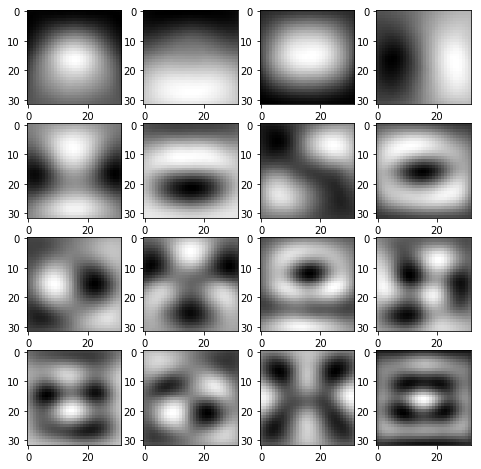

In [6]:
# TODO: Show principle components of P using a 4x4 subplot
# Visualize P
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = np.reshape(P[r*i+j], [32,32])
        axarr[i][j].imshow(img, cmap="gray")

(16, 32, 32)


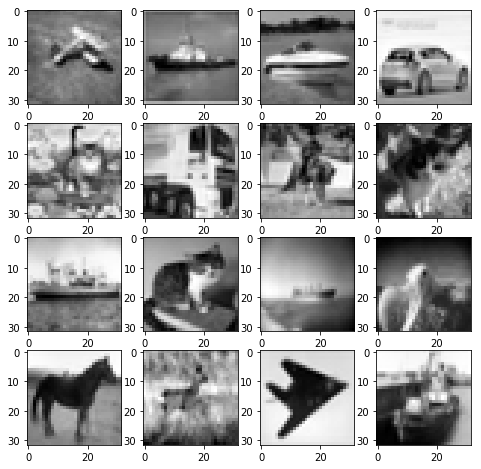

In [11]:
# Select a small set of images for test
num_training = 50000
num_pca = 16
mask = np.random.choice(num_training, num_pca, replace=False)
X_pca = X_train[mask,:,:,0]

# Visualize one channel of images 
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_pca[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

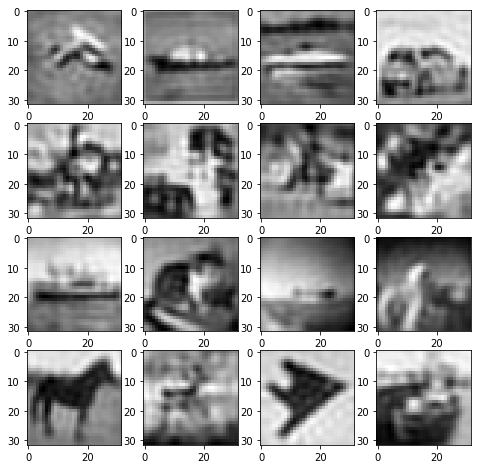

In [12]:
# TODO: Test your result
# Reduce dimension with P
X_features = []
for n in range(num_pca):
    img = X_pca[n]
    feature = np.dot(P, np.reshape(img, (-1,)))
    X_features.append(feature)

# Reconstruct image
X_recon = []
for n in range(num_pca):
    feature = X_features[n]
    img = np.reshape(np.dot(feature, P), (32,32))
    X_recon.append(img)

# Visualize results
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_recon[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

### PCA + Neural network

<span style="color:red"><strong>TODO</strong></span>: Use PCA to preprocess images before training a neural network: 

1. Do PCA preprocessing on each channel of the original image separately.
2. Stack PCA features from three channels into one vector, and use that vector as an input for MLP.
3. Train the MLP and show the results. 

In [10]:
from ecbm4040.train_funcs import train, test
from ecbm4040.classifiers.mlp import MLP
# TODO: pca preprocessing -> mlp classification

train_size = X_train.shape[0]
val_size = X_val.shape[0]
test_size = X_test.shape[0]
X_train_recon = np.zeros(X_train.shape)
X_val_recon = np.zeros(X_val.shape)
X_test_recon = np.zeros(X_test.shape)

for k in range(3):
    X_features = []
    for i in range(train_size):
        img = X_train[i, :, :, k]
        feature = np.dot(P, np.reshape(img, (-1,)))
        X_features.append(feature)
    X_train_recon_temp = []
    for i in range(train_size):
        feature = X_features[i]
        img = np.reshape(np.dot(feature, P), (32,32))
        X_train_recon_temp.append(img)
    X_train_recon[:, :, :, k] = np.asarray(X_train_recon_temp)
X_train_recon = np.transpose(X_train_recon, (0, 3, 1, 2))
X_train_recon = np.reshape(X_train_recon, [train_size, 3072])
    
for k in range(3):
    X_features = []
    for i in range(val_size):
        img = X_val[i, :, :, k]
        feature = np.dot(P, np.reshape(img, (-1,)))
        X_features.append(feature)
    X_val_recon_temp = []
    for i in range(val_size):
        feature = X_features[i]
        img = np.reshape(np.dot(feature, P), (32,32))
        X_val_recon_temp.append(img)
    X_val_recon[:, :, :, k] = np.asarray(X_val_recon_temp)  
X_val_recon = np.transpose(X_val_recon, (0, 3, 1, 2))
X_val_recon = np.reshape(X_val_recon, [X_val_recon.shape[0], 3072])
    
for k in range(3):
    X_features = []
    for i in range(test_size):
        img = X_test[i, :, :, k]
        feature = np.dot(P, np.reshape(img, (-1,)))
        X_features.append(feature)
    X_test_recon_temp = []
    for i in range(test_size):
        feature = X_features[i]
        img = np.reshape(np.dot(feature, P), (32,32))
        X_test_recon_temp.append(img)
    X_test_recon[:, :, :, k] = np.asarray(X_test_recon_temp)
X_test_recon = np.transpose(X_test_recon, (0, 3, 1, 2))
X_test_recon = np.reshape(X_test_recon, [X_test_recon.shape[0], 3072])


<span style="color:red"><strong>TODO</strong></span>: Plot training, validation and test set accuracy.

number of batches for training: 98
5000/49000 loss: 2.326744156134339
10000/49000 loss: 2.3205331100516817
15000/49000 loss: 2.311658514652076
20000/49000 loss: 2.297998521206617
25000/49000 loss: 2.2874778563352827
30000/49000 loss: 2.2897071847513817
35000/49000 loss: 2.2880738068601993
40000/49000 loss: 2.2886717702341524
45000/49000 loss: 2.2459346817301307
epoch 1: valid acc = 0.16, new learning rate = 0.02375
5000/49000 loss: 2.2152514866858026
10000/49000 loss: 2.221818541840613
15000/49000 loss: 2.2241905920328495
20000/49000 loss: 2.1979092912837097
25000/49000 loss: 2.209485290422543
30000/49000 loss: 2.1689752559746
35000/49000 loss: 2.19966567453955
40000/49000 loss: 2.205743907957738
45000/49000 loss: 2.1630705173225127
epoch 2: valid acc = 0.191, new learning rate = 0.0225625
5000/49000 loss: 2.1479628577116197
10000/49000 loss: 2.1798838710813384
15000/49000 loss: 2.2043297707195437
20000/49000 loss: 2.185794383555177
25000/49000 loss: 2.199138363386848
30000/49000 loss:

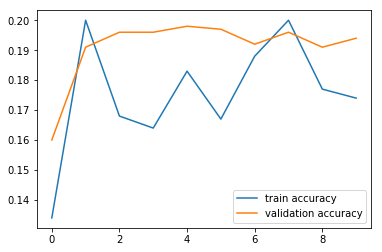

In [23]:
# TODO:
model = MLP(input_dim=3072, hidden_dims=[100, 50, 50], num_classes=10, reg=0.25, weight_scale=1.5e-3)

num_epoch = 10
batch_size = 500
lr = 2.5e-2
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train_recon, y_train, X_val_recon, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test_acc = test(model, X_test_recon, y_test)

plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

## Part 2: t-SNE (not graded)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR10. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [14]:
from ecbm4040.features.tsne import tsne

#### tSNE of original data

In [15]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test[random_select,:,:,0].reshape(500,1024).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.5366204854
The 100 th loop cost: 14.877397092563585, computation time: 3.286860227584839
The 200 th loop cost: 1.171235899891658, computation time: 6.758795261383057
The 300 th loop cost: 1.1670574047194004, computation time: 9.755503177642822
The 400 th loop cost: 1.1661263245335476, computation time: 12.702183485031128
The 500 th loop cost: 1.166049126741146, computation time: 15.650585651397705
The 600 th loop cost: 1.166048962414655, computation time: 18.60441303253174
The 700 th loop cost: 1.1660489616819323, computation time: 21.578539848327637
The 800 th loop cost: 1.166048961680435, computation time: 24.5250301361084
The 900 th loop cost: 1.1660489616804268, computation time: 27.44602656364441
The 1000 th loop cost: 1.1660489616804264, computation time: 30.337982416152954
it takes 31.131248474121094 seconds


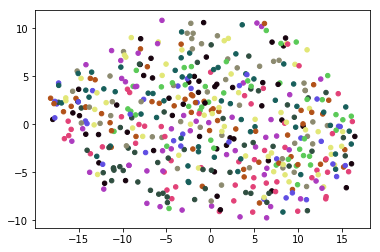

In [16]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, the tSNE of data after two-layer networks is shown as multiple clusters in a 2D panel.

In [18]:
# Define MLP model
model = MLP(input_dim=3072, hidden_dims=[100], num_classes=10, reg=0.1, weight_scale=1e-2)

X_train = X_train.reshape([X_train.shape[0], -1])
X_val = X_val.reshape([X_val.shape[0], -1])
X_test = X_test.reshape([X_test.shape[0], -1])

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245


C:\Users\dell\assignment1\ecbm4040\classifiers\softmax.py:83: RuntimeWarning: divide by zero encountered in log
  loss -= np.sum(np.log(vec[np.arange(N), y]))


epoch 1: valid acc = 0.327, new learning rate = 0.00095
epoch 2: valid acc = 0.402, new learning rate = 0.0009025
epoch 3: valid acc = 0.444, new learning rate = 0.000857375
epoch 4: valid acc = 0.47, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.477, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.491, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.506, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.511, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.517, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.522, new learning rate = 0.0005987369392383785
test acc: 0.4866


0.48659999999999998

In [19]:
# run tSNE
X = X_test[random_select]
X = model.layers[0].feedforward(X)
X = model.layers[1].feedforward(X)
X_exp = np.exp(X)
X = X_exp / np.tile(np.sum(X_exp, axis=1, keepdims=True), 10)

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

0.190134012633
The 100 th loop cost: 11.1789661073522, computation time: 2.9411633014678955
The 200 th loop cost: 0.49376482497522445, computation time: 6.038201570510864
The 300 th loop cost: 0.475549508670812, computation time: 8.999395370483398
The 400 th loop cost: 0.47370775134816917, computation time: 11.912820816040039
The 500 th loop cost: 0.47349991733467567, computation time: 15.074660778045654
The 600 th loop cost: 0.47346503477182267, computation time: 18.070818185806274
The 700 th loop cost: 0.47345857811118225, computation time: 21.003234386444092
The 800 th loop cost: 0.4734572925858386, computation time: 23.92703413963318
The 900 th loop cost: 0.4734570370044766, computation time: 26.838353872299194
The 1000 th loop cost: 0.4734569853596333, computation time: 29.775815963745117
it takes 30.467794179916382 seconds


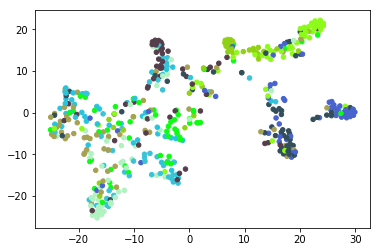

In [20]:
# visualize tSNE 2D representation of data after two hidden layers
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()